In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from collections import Counter, defaultdict, namedtuple, OrderedDict
from pomegranate import State, HiddenMarkovModel, DiscreteDistribution
import os

import matplotlib.pyplot as plt

import itertools

import seaborn as sn

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

In [2]:
# Replaces unknown values for nan
def replace_unknown(sequence):
    
    return [w if w in trainVocab else 'nan' for w in sequence]


def simplify_decoding(X, model):
    
    _, state_path = model.viterbi(replace_unknown(X))
    return [state[1].name for state in state_path[1:-1]]

# Function that calculates the accuracy of the model,
# it receives the data separated in tokens and tags (X and Y)
# and the model in question
def accuracy(X, Y, model):
    
    correct = total_predictions = 0
    predictions = []
    for observations, actual_tags in zip(X, Y):
        
        # The model.viterbi call in simplify_decoding will return None if the HMM
        # raises an error (for example, if a test sentence contains a word that
        # is out of vocabulary for the training set). Any exception counts the
        # full sentence as an error (which makes this a conservative estimate).
        try:

            most_likely_tags = simplify_decoding(observations, model)
            predictions.extend(most_likely_tags)
            correct += sum(p == t for p, t in zip(most_likely_tags, actual_tags))
        except:
            pass
        total_predictions += len(observations)
    return correct / total_predictions , predictions


In [3]:
# Returns a dictionary that contains how many times
# an element appears in the sequence
def counts(sequences):

    return Counter(sequences)


# Function that makes a dictionary counting the appearance
# of every pair of (tag,word). Returns the created dictionary
def pair_counts(tags, words):
    d = defaultdict(lambda: defaultdict(int))
    for tag, word in zip(tags, words):
        d[tag][word] += 1
    
    return d


# Function that makes a dictionary counting how often in the datasey
# a pair of tags appear together. Returns the created dictionary
def tag_bigram(tags):
    
    d = defaultdict(lambda: defaultdict(int))
    for pair in [p for p in itertools.product(['B','I','O'], repeat=2)]:
        d[pair] = 0
        
    for tag_pair in [(tags[i],tags[i+1]) for i in range(0,len(tags)-2,2)]:
        
        d[tag_pair] += 1
    
    return d


In [4]:
# Function that receives the parameters to send to the algorithm
# as well as the data that will be used to train the model.
def trainHmm(dataList,tagList):
    
    basic_model = HiddenMarkovModel(name="base-hmm-tagger")

    data_pairs =[item for sublist in dataList for item in sublist]

    tags = [tag for (word, tag) in data_pairs]
    words = [word for (word, tag) in data_pairs]

    tags_count=counts(tags)                  #the number of times a tag occured 
    tag_words_count=pair_counts(tags,words)  #the number of times a pair of (tag,word) ocurred

    starting_tag_list=[i[0] for i in tagList]
    ending_tag_list=[i[-1] for i in tagList]

    starting_tag_count=counts(starting_tag_list)  #the number of times a tag occured at the start
    ending_tag_count=counts(ending_tag_list)      #the number of times a tag occured at the end

    tag_bigrams = tag_bigram(tags)

    to_pass_states = []
    for tag, words_dict in tag_words_count.items():
        total = float(sum(words_dict.values()))
        distribution = {word: count/total for word, count in words_dict.items()}
        tag_emissions = DiscreteDistribution(distribution)
        tag_state = State(tag_emissions, name=tag)
        to_pass_states.append(tag_state)


    basic_model.add_states()    


    start_prob={}

    for tag in tags:
        start_prob[tag]=starting_tag_count[tag]/tags_count[tag]

    for tag_state in to_pass_states :
        basic_model.add_transition(basic_model.start,tag_state,start_prob[tag_state.name])    

    end_prob={}

    for tag in tags:
        end_prob[tag]=ending_tag_count[tag]/tags_count[tag]
    for tag_state in to_pass_states :
        basic_model.add_transition(tag_state,basic_model.end,end_prob[tag_state.name])



    transition_prob_pair={}

    for key in tag_bigrams.keys():
        transition_prob_pair[key]=tag_bigrams.get(key)/tags_count[key[0]]

    for tag_state in to_pass_states :
        for next_tag_state in to_pass_states :
            basic_model.add_transition(tag_state,next_tag_state,transition_prob_pair[(tag_state.name,next_tag_state.name)])

    basic_model.bake()
    
    return basic_model

In [5]:
# Generates a heatmap graph with the data provided.
# 'true_values' corresponds to the real labels of the data,
# 'pred' are the labels predicted by the model and 'values'
# are all the possible labels.
def heatmapGraph(true_values,pred,values):

    cm = confusion_matrix(true_values,pred, labels=values)
    ax= plt.subplot()
    sn.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")
    ax.set_title('Confusion Matrix')
       
    ax.set_xlabel("Prediction")
    ax.set_ylabel("Real Values")
        
    ax.xaxis.set_ticklabels(values)
    ax.yaxis.set_ticklabels(values)
    return

In [6]:
# Function that runs the model with the test data, it receives
# the model, the data as features (x_test) and the labels corresponding
# the data (y_test). It also generates the classification report,
# calculates the training and testing accuracy and calls the 
# heatmap graph function.
def testHmm(model,trainDataX,trainDataY,testDataX,testDataY):
    
    hmm_training_acc, train_pred= accuracy(trainDataX, trainDataY, basic_model)
    print("Training accuracy basic hmm model: {:.2f}%".format(100 * hmm_training_acc))

    hmm_testing_acc, test_pred= accuracy(testDataX, testDataY, basic_model)
    print("Testing accuracy basic hmm model: {:.2f}%".format(100 * hmm_testing_acc))
    

    testDataYFlat = [item for sublist in testDataY for item in sublist]
    
    print(classification_report(testDataYFlat,test_pred, digits=4))

    heatmapGraph(testDataYFlat,test_pred,['B','I','O'])
    
    
    return test_pred

**Algorithm sources**

https://github.com/susanli2016/NLP-with-Python/blob/master/Hidden%20Markov%20Models%20for%20POS.ipynb

**Testing the algorithm with the data**

d:\program files\python\python 3.8.6\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (1,3) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-7-4f15dc96cc7b>:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  datos = datos.groupby('sequence')['token','pos','ner_tag'].agg(list)


Training accuracy basic hmm model: 99.22%
Testing accuracy basic hmm model: 99.08%
              precision    recall  f1-score   support

           B     0.9776    0.9824    0.9800      4261
           I     0.8346    0.9713    0.8977       348
           O     0.9962    0.9927    0.9945     22137

    accuracy                         0.9908     26746
   macro avg     0.9361    0.9821    0.9574     26746
weighted avg     0.9912    0.9908    0.9909     26746



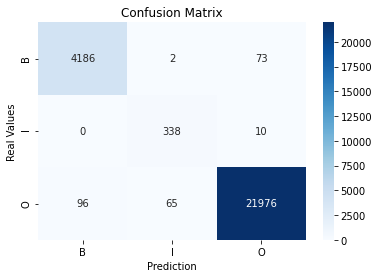

In [7]:
datos = pd.read_csv("data/atta_specimen_ner.csv",keep_default_na=False, na_values=[''])

datos = datos.groupby('sequence')['token','pos','ner_tag'].agg(list)

tokenList = datos['token'].tolist()
tagList = datos['ner_tag'].tolist()

dataList = []
for x,y in zip(tokenList,tagList):
    dataList.append(list(zip(x,y)))
    
trainDataX,testDataX,trainDataY,testDataY = train_test_split(tokenList,tagList, test_size=0.2, random_state = 42)

trainVocab =set([item for sublist in trainDataX for item in sublist])

basic_model = trainHmm(dataList,tagList)

preds = testHmm(basic_model,trainDataX,trainDataY,testDataX,testDataY)

In [ ]:
for i in range(0,len(testDataX)):
    print("Sentence : {}\n".format(testDataX[i]))
    print("Index of data: {}\n".format(i))
    print("Predicted labels:\n-----------------")
    print(simplify_decoding(testDataX[i], basic_model))
    print()
    print("Actual labels:\n--------------")
    print(testDataY[i])
    print("\n")